In [ ]:

from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lab 4:	Music	Mood	Classification

## Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [ ]:
data_path = '/content/drive/Shareddrives/BioML/Lab 4/Data/'
results_path = '/content/drive/Shareddrives/BioML/Lab 4/Results'

# Import Data

In [ ]:
train_data = pd.read_csv(data_path + 'TrainSet.csv', na_values="NaN ").set_index("File_Name")
test_data = pd.read_csv(data_path + 'TestSet.csv', na_values="NaN ").set_index("File_Name")

In [ ]:
train_data.head()

,Em,Ed,El,LEm,ATm,Asm,ASd,EDm,FPm,FMm,FCm,Tm,Td,PCm,PCd,Pm,Pd,Cm,Cd,Cl,Chh,KCm,KCd,Mm,Md,Hm,ESm,Rm,Im,Id,Bm,Bd,SCm,SCd,Zm,Zd,Sm,Km,SEm,SEd,SFm,Fm,REm,REd,M1m,D1m,M2m,D2m,M3m,D3m,M4m,D4m,M5m,D5m,M6m,D6m,M7m,D7m,RSm,RSd,RRm,RRd,RTm,RTd,RGm,RGd,class
File_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01-anarchy_in_the_uk.mp3,0.228523,0.005756,0.003345,0.563593,0.057984,3.457377e+06,2.521368e+06,5.243943,866.0,2565.374571,4.762277,126.718170,19.666472,0.397315,0.106398,408.412788,442.996199,-0.0,0.323550,0.166496,-4.101857e+10,0.420444,0.130082,-0.017369,0.107559,0.345390,0.905387,3619.495074,NaN,NaN,0.940470,0.034812,3396.545704,439.655042,2328.285004,851.761783,0.508033,8.945467e+10,0.812774,0.023610,172.473362,0.051199,0.664844,0.337087,-0.146897,-0.000118,0.833008,0.000351,0.921700,-0.000133,0.022229,0.000397,0.376699,-0.000076,0.022692,0.000075,0.232818,-0.000118,43.800431,21.912391,55.806736,57.279056,41.248632,21.913723,43.028042,22.847610,aggressive
01-angel_of_death.mp3,0.231866,0.007204,0.005113,0.529508,0.049326,6.534186e+06,3.843431e+06,7.434451,1345.0,3367.889134,4.930499,108.108581,1.681632,0.518697,0.104838,520.155022,428.846572,0.0,0.315773,0.123521,-3.297215e+10,0.415858,0.139823,-0.022049,0.100651,0.309975,0.930247,3964.756518,NaN,NaN,0.923775,0.045507,3959.979599,634.371768,2520.687655,727.266019,0.642009,2.158531e+11,0.860450,0.025233,212.477016,0.100474,0.363805,0.197516,0.584335,0.000389,0.262653,-0.000713,0.986105,-0.000706,-0.023722,-0.000168,0.068411,-0.000416,0.056250,0.000221,0.129234,0.000176,28.242499,12.775416,15.886451,13.327719,36.544511,13.637614,36.336147,13.062584,aggressive
01-back_to_the_primitive.mp3,0.332185,0.006607,0.004470,0.493776,0.048627,7.084042e+06,3.847330e+06,7.334882,1403.0,3417.223960,4.968372,129.990704,20.935455,0.547348,0.042528,285.804771,398.324879,-0.0,0.145033,0.150764,-1.899232e+10,0.464818,0.149504,-0.060122,0.098119,0.278920,0.870816,3033.681950,NaN,NaN,0.800001,0.062942,1995.620370,351.643831,717.191384,289.136615,0.552050,2.000295e+11,0.740376,0.034017,213.934192,0.079447,0.607757,0.343329,1.204622,0.000237,-0.219528,-0.000071,1.160033,0.000292,-0.130961,0.000048,0.356172,0.000437,0.228271,-0.000190,0.326001,-0.000410,48.627341,27.925648,55.329468,45.522860,41.719539,19.529773,43.087762,20.105442,aggressive
01-born_on_the_cusp.mp3,0.347160,0.008825,0.004168,0.528738,0.058384,6.538634e+06,4.441305e+06,4.825737,627.0,2225.553866,4.748791,133.989811,39.106680,0.245110,0.086794,705.423735,305.687307,-0.0,0.335319,0.197671,-2.164417e+10,0.436574,0.144302,0.054788,0.110884,0.324216,0.913961,5725.562558,NaN,NaN,0.922148,0.044840,3161.509156,523.844377,1589.657191,497.833599,0.536702,4.321165e+11,0.832485,0.024632,285.776047,0.136575,0.491490,0.242739,1.646384,0.000026,-0.028157,-0.000626,0.375822,-0.000900,-0.028648,-0.000401,0.148115,-0.000063,-0.041656,0.000448,0.124650,0.000496,39.098973,16.653536,22.606410,13.184925,43.178580,13.889276,52.134777,17.766253,aggressive
01-cold_cash_and_cold_hearts.mp3,0.307836,0.009545,0.006795,0.624839,0.067600,1.056926e+07,1.034890e+07,3.910991,1214.0,4333.999027,4.689145,161.653965,37.930780,0.391863,0.192838,566.207406,415.206152,-0.0,0.202938,0.171353,-2.376201e+10,0.515598,0.139257,-0.033408,0.113986,0.338089,0.914913,2736.176621,NaN,NaN,0.881098,0.070154,3198.373699,780.138255,1553.187553,652.208511,0.626537,2.572760e+11,0.816708,0.044646,225.155910,0.146913,0.596109,0.250870,1.131027,-0.000597,-0.236746,0.000121,0.685641,-0.000587,-0.023808,-0.000050,0.172296,0.000238,0.044588,0.000188,0.129557,-0.000238,70.602915,55.540702,84.173088,74.933277,89.995850,69.841522,91.929329,66.362908,aggressive


# Data Processing

In [ ]:
train_data["class"].unique()

array(['aggressive', 'happy', 'relaxed', 'sad'], dtype=object)

In [ ]:
# Drop missing values, since we have few data, replace nan's by 0 and also infinite values

train_data = train_data.replace([np.inf, -np.inf, "NaN "], np.nan)
train_data = train_data.fillna(0)

test_data = test_data.replace([np.inf, -np.inf, "NaN "], np.nan)
test_data = test_data.fillna(0)

In [ ]:
# Encode column class to numeric
encoder = {"class": {'aggressive': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}}

In [ ]:
train_data = train_data.replace(encoder)
test_data = test_data.replace(encoder)

In [ ]:
# split datasets
X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]

X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

In [ ]:
X_train.describe()

,Em,Ed,El,LEm,ATm,Asm,ASd,EDm,FPm,FMm,FCm,Tm,Td,PCm,PCd,Pm,Pd,Cm,Cd,Cl,Chh,KCm,KCd,Mm,Md,Hm,ESm,Rm,Im,Id,Bm,Bd,SCm,SCd,Zm,Zd,Sm,Km,SEm,SEd,SFm,Fm,REm,REd,M1m,D1m,M2m,D2m,M3m,D3m,M4m,D4m,M5m,D5m,M6m,D6m,M7m,D7m,RSm,RSd,RRm,RRd,RTm,RTd,RGm,RGd
count,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.0,60.000000,60.000000,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.201437,0.007214,0.003355,0.545064,0.071504,3.822211e+06,3.288246e+06,3.192980,864.983333,6812.312620,4.718479,124.122507,25.552421,0.390203,0.084954,447.211923,326.337140,0.0,0.264307,0.241392,-2.690224e+10,0.531371,0.141700,-0.022185,0.107071,0.325791,0.886190,1824.103474,0.038994,0.002077,0.842882,0.057125,2526.535860,692.867263,1372.206166,655.939913,0.799426,1.351540e+11,0.753064,0.049046,131.022528,0.093099,0.631350,0.324422,2.225702,0.000118,0.064896,0.000013,0.672662,0.000024,0.098788,-0.000028,0.183195,-0.000056,0.086771,0.000158,0.094638,0.000106,80.979620,45.368941,71.725445,49.261164,85.272480,58.460259,94.789202,56.691629
std,0.071356,0.001942,0.001445,0.047511,0.022889,2.644270e+06,2.174100e+06,1.705752,275.314211,4456.247687,0.213173,27.366417,12.677485,0.151237,0.036235,134.507427,107.804413,0.0,0.075981,0.083528,6.890115e+09,0.064265,0.021288,0.036171,0.021480,0.053984,0.044526,1560.439933,0.130488,0.007532,0.231629,0.030389,1267.339276,355.207381,894.479957,345.559724,0.215186,9.509412e+10,0.076909,0.018821,66.038254,0.043783,0.128838,0.067031,1.337102,0.001455,0.449546,0.000959,0.317421,0.000721,0.251440,0.000616,0.211420,0.000594,0.133484,0.000507,0.171043,0.000523,30.095051,19.734245,31.141563,25.509092,29.668328,25.044434,34.170039,23.650426
min,0.073071,0.004206,0.001211,0.404296,0.048423,5.765024e+05,7.201662e+05,0.199137,354.000000,1691.889809,4.240887,0.000000,0.000000,0.132376,0.024808,212.905190,66.066902,0.0,0.130050,0.108034,-4.101857e+10,0.373306,0.058927,-0.101163,0.029530,0.159729,0.770021,63.026819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.969900,111.699218,0.434044,1.741156e+10,0.608327,0.022435,23.891166,0.014309,0.363805,0.197516,-0.692925,-0.003865,-1.410431,-0.001943,-0.696683,-0.001617,-0.684945,-0.001369,-0.749976,-0.001652,-0.308311,-0.001055,-0.639464,-0.001135,28.242499,11.380713,14.897753,8.497781,17.314847,13.637614,16.601253,12.556038
25%,0.146986,0.005788,0.002344,0.515787,0.057864,1.970200e+06,1.855405e+06,1.985357,661.250000,3425.191034,4.564794,117.791619,17.720506,0.244186,0.057085,340.068176,283.905354,0.0,0.211548,0.190354,-3.213145e+10,0.485936,0.132857,-0.043693,0.099078,0.295731,0.867063,496.129686,0.000000,0.000000,0.862305,0.038480,1748.902845,467.461442,688.111657,410.441078,0.660808,6.270474e+10,0.693937,0.031838,82.234504,0.063710,0.546999,0.281953,1.470560,-0.000630,-0.147114,-0.000620,0.529639,-0.000543,-0.025018,-0.000494,0.081782,-0.000423,-0.001491,-0.000234,0.018588,-0.000264,60.373229,29.518373,49.708638,34.280757,63.769281,35.806285,69.968871,37.416127
50%,0.195201,0.006932,0.003237,0.541256,0.065606,3.330854e+06,2.662884e+06,2.907366,831.000000,5693.971063,4.732739,126.993442,28.122344,0.420018,0.084653,454.944880,358.085977,0.0,0.255139,0.233487,-2.705993e+10,0.543423,0.147903,-0.021730,0.108148,0.336170,0.901954,1392.276550,0.000000,0.000000,0.909185,0.050674,2575.268073,754.814639,1290.937777,651.993672,0.781875,1.043811e+11,0.762643,0.048673,114.593780,0.085247,0.614675,0.324294,2.052214,0.000146,0.026644,-0.000106,0.663056,-0.000034,

# Obtain importances

In [ ]:
#scale predictors
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [ ]:
np.isnan(X_train_scaled).sum()

0

## From coefficients

In [ ]:

model = LogisticRegression(solver='liblinear')
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

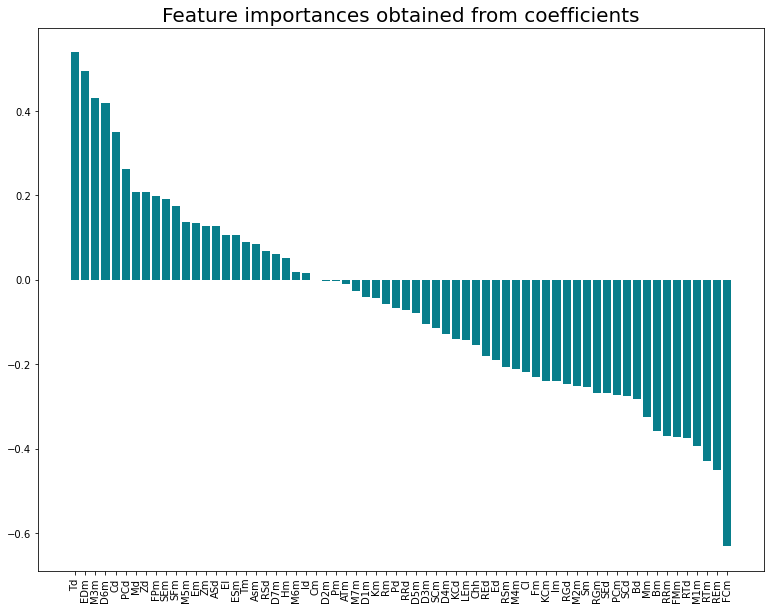

In [ ]:
plt.rcParams["figure.figsize"] = (13,10)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Using PCA


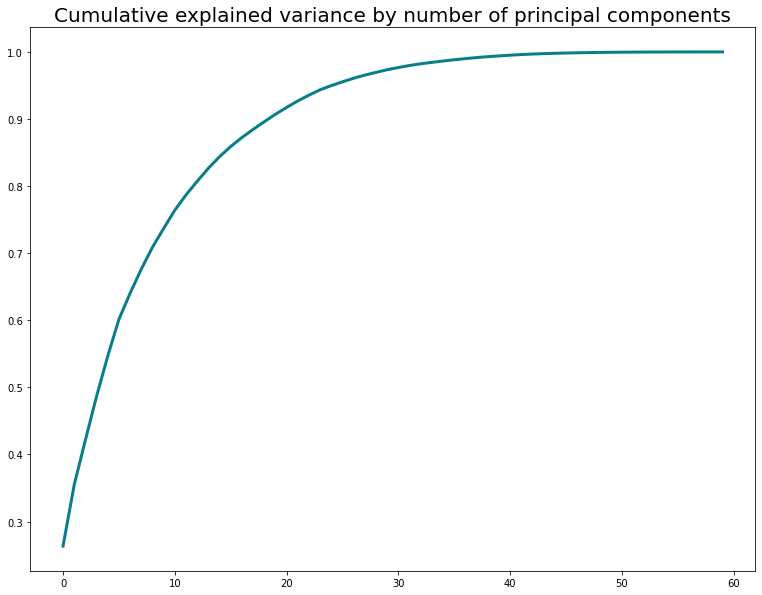

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [ ]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i}' for i in range(1, X_train.shape[0]+1)],
    index=X_train.columns
)

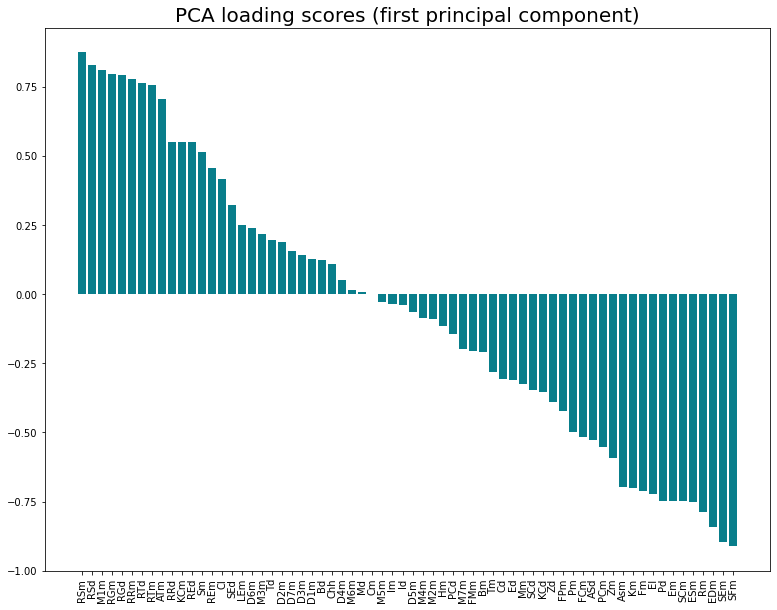

In [ ]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.rcParams["figure.figsize"] = (13,10)

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

sfs = SFS(LinearRegression(),
           k_features=20,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
sfs.fit(X_train_scaled, y_train)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(58,)",[0.6552461016781674],0.655246,"(58,)"
2,"(40, 58)",[0.7557677921084043],0.755768,"(40, 58)"
3,"(40, 42, 58)",[0.7900267708459616],0.790027,"(40, 42, 58)"
4,"(14, 40, 42, 58)",[0.8107748494410133],0.810775,"(14, 40, 42, 58)"
5,"(14, 37, 40, 42, 58)",[0.8211822513863731],0.821182,"(14, 37, 40, 42, 58)"
6,"(14, 26, 37, 40, 42, 58)",[0.834046448041964],0.834046,"(14, 26, 37, 40, 42, 58)"
7,"(14, 18, 26, 37, 40, 42, 58)",[0.8437314793628746],0.843731,"(14, 18, 26, 37, 40, 42, 58)"
8,"(14, 15, 18, 26, 37, 40, 42, 58)",[0.8530599526309288],0.85306,"(14, 15, 18, 26, 37, 40, 42, 58)"
9,"(14, 15, 18, 26, 37, 40, 42, 43, 58)",[0.8618824481829348],0.861882,"(14, 15, 18, 26, 37, 40, 42, 43, 58)"
10,"(14, 15, 18, 21, 26, 37, 40, 42, 43, 58)",[0.8709892853536586],0.870989,"(14, 15, 18, 21, 26, 37, 40, 42, 43, 58)"


In [ ]:
df_SFS_results.feature_names.iloc[19]

('10',
 '11',
 '14',
 '15',
 '18',
 '21',
 '25',
 '26',
 '37',
 '40',
 '42',
 '43',
 '44',
 '45',
 '51',
 '52',
 '55',
 '58',
 '62',
 '64')

## Using Variance Threshold


In [ ]:
# remove almost constant features
constant_filter = VarianceThreshold(threshold=0.4)


In [ ]:
# apply this filter to our training set
constant_filter.fit(X_train)


VarianceThreshold(threshold=0.4)

In [ ]:
# number of non-constant features
len(X_train.columns[constant_filter.get_support()])

26

In [ ]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]

for column in constant_columns:
    print(column)

Em
Ed
El
LEm
ATm
FCm
PCm
PCd
Cm
Cd
Cl
KCm
KCd
Mm
Md
Hm
ESm
Im
Id
Bm
Bd
Sm
SEm
SEd
Fm
REm
REd
D1m
M2m
D2m
M3m
D3m
M4m
D4m
M5m
D5m
M6m
D6m
M7m
D7m


In [ ]:
X_train_filtered = constant_filter.transform(X_train)
X_test_filtered = constant_filter.transform(X_test)


In [ ]:
X_train.columns

Index(['Em', 'Ed', 'El', 'LEm', 'ATm', 'Asm', 'ASd', 'EDm', 'FPm', 'FMm', 'FCm', 'Tm', 'Td', 'PCm', 'PCd', 'Pm', 'Pd', 'Cm', 'Cd', 'Cl', 'Chh', 'KCm', 'KCd', 'Mm', 'Md', 'Hm', 'ESm', 'Rm', 'Im', 'Id', 'Bm', 'Bd', 'SCm', 'SCd', 'Zm', 'Zd', 'Sm', 'Km', 'SEm', 'SEd', 'SFm', 'Fm', 'REm', 'REd', 'M1m', 'D1m', 'M2m', 'D2m', 'M3m', 'D3m', 'M4m', 'D4m', 'M5m', 'D5m', 'M6m', 'D6m', 'M7m', 'D7m', 'RSm', 'RSd', 'RRm', 'RRd', 'RTm', 'RTd', 'RGm', 'RGd'], dtype='object')

# SECOND TASK

In [ ]:
sfs_features = [10, 11, 14, 15, 18, 21, 25, 26, 37, 40, 42, 43, 44, 45, 51, 52, 55, 58, 62, 64]
labels = ['aggresive', 'happy', 'relaxed', 'sad']

X_train_sfs = train_data.iloc[:,sfs_features]
y_train_sfs = train_data.iloc[:,-1]

X_test_sfs = test_data.iloc[:,sfs_features]
y_test_sfs = test_data.iloc[:,-1]

In [ ]:
x = X_train_sfs.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train_sfs = pd.DataFrame(x_scaled, columns=X_train_sfs.columns, index=X_train_sfs.index)

In [ ]:
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_train_sfs)
encoded_Y = encoder.transform(y_train_sfs)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
x = X_test_sfs.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_test_sfs = pd.DataFrame(x_scaled, columns=X_test_sfs.columns, index=X_test_sfs.index)
X_test_sfs.shape

(20, 20)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_test_sfs)
encoded_Y_test = encoder.transform(y_test_sfs)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(60, input_dim=20, activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_sfs, dummy_y, epochs=200, batch_size=32, verbose=0)

_,accuracy = model.evaluate(X_test_sfs, dummy_y_test)

print('Accuracy: %.2f' % (accuracy*100))


1/1 [==============================] - 0s 288ms/step - loss: 1.1669 - accuracy: 0.4500
Accuracy: 45.00


In [ ]:
dummy_y_test = np.where(dummy_y_test==1)[1]

In [ ]:
y_pred = (model.predict(X_test_sfs) > 0.5).astype("int32")
y_pred = np.where(y_pred==1)[1]

In [ ]:
y_pred, dummy_y_test

(array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]))

In [ ]:
different_songs = (np.where(y_pred != dummy_y_test))[0].tolist()
X_test_sfs.iloc[different_songs]

,FCm,Tm,PCd,Pm,Cd,KCm,Hm,ESm,Km,SFm,REm,REd,M1m,D1m,D4m,M5m,D6m,RSm,RTm,RGm
File_Name,,,,,,,,,,,,,,,,,,,,
02-baby_i_ve_got_you_on_my_mind.mp3,0.524662,0.801554,0.632263,0.771354,0.124572,0.500348,0.751800,0.639653,1.000000,0.925069,0.455200,0.164746,0.397579,0.219147,0.904505,0.311978,0.575104,0.298670,0.185899,0.243390
02-call_n_return.mp3,0.256904,0.718849,0.169078,0.458744,0.742085,0.410746,0.920935,0.808645,0.795781,0.855171,0.606870,0.634829,0.322180,0.543557,0.851652,0.000000,0.576495,0.113511,0.207114,0.199313
02-donnie.mp3,0.587795,0.768996,0.028671,0.776656,0.557981,0.618794,0.791995,0.929876,0.650955,0.907092,0.349281,0.372163,0.335187,0.000000,0.585586,0.437378,0.463839,0.135354,0.134917,0.116416
02-dream_world.mp3,0.589842,0.777799,0.376667,0.676041,0.834535,1.000000,0.666715,0.810092,0.292006,0.318453,0.086837,0.000000,0.395890,1.000000,0.681081,0.504155,0.235049,0.226910,0.182105,0.179647
01-snow_falls_in_november.mp3,0.000000,0.657115,0.328867,0.029008,0.112123,0.946610,0.579978,0.063861,0.088462,0.072253,0.665293,0.680916,1.000000,0.467332,0.416817,0.614347,0.060501,0.591759,0.448439,0.476759
01-speed_trials.mp3,0.539744,0.637041,0.220180,0.718986,0.490725,0.252950,0.710299,0.212735,0.242611,0.244214,0.161502,0.200098,0.758931,0.185572,0.538138,0.580731,0.253129,0.577113,0.600456,0.564019
01-st._stephen.mp3,0.820306,0.698177,0.334107,0.231180,0.000000,0.740241,0.749157,0.000000,0.277747,0.153753,0.580127,0.546160,0.917056,0.441697,0.951351,0.253299,1.000000,0.778517,0.725856,0.761312
01-sweet_adeline.mp3,0.462132,0.822811,1.000000,0.000000,0.194815,0.258393,0.902763,0.077337,0.055896,0.145919,1.000000,0.775411,0.818472,0.356397,0.607808,0.599651,0.378303,0.874209,0.826349,0.727278
01-treat_u_rite.mp3,0.770914,0.000000,0.017674,0.327200,1.000000,0.486149,1.000000,0.528723,0.176399,0.364110,0.292709,0.624471,0.547571,0.483666,0.099099,0.000069,0.221836,0.376874,0.210180,0.349256


In [ ]:
y_test[different_songs]

File_Name
02-baby_i_ve_got_you_on_my_mind.mp3           1
02-call_n_return.mp3                          1
02-donnie.mp3                                 1
02-dream_world.mp3                            1
01-snow_falls_in_november.mp3                 2
01-speed_trials.mp3                           2
01-st._stephen.mp3                            2
01-sweet_adeline.mp3                          2
01-treat_u_rite.mp3                           2
02-padraic_my_prince.mp3                      3
03-ana_s_song_open_fire.mp3                   3
Name: class, dtype: int64

In [ ]:
y_pred[different_songs]

array([0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 1])

In [ ]:
np.where(y_pred != dummy_y_test)

(array([ 5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 17]),)

In [ ]:
confusion_matrix(dummy_y_test, y_pred)

array([[5, 0, 0, 0],
       [4, 1, 0, 0],
       [0, 1, 0, 4],
       [0, 2, 0, 3]])

In [ ]:
data = {
    'Y_pred' : y_pred[different_songs],
    'Y_test' : y_test_sfs.iloc[different_songs]    
}
encoder1 = {
    "Y_pred" : {
        0 : 'aggresive',
        1 : 'happy',
        2 : 'relaxed',
        3 : 'sad'
    }
}
encoder2 = {
    "Y_test" : {
        0 : 'aggresive',
        1 : 'happy',
        2 : 'relaxed',
        3 : 'sad'
    }
}

songs_that_differ = pd.DataFrame(data)
songs_that_differ.replace(encoder1,inplace=True)
songs_that_differ.replace(encoder2,inplace=True)
songs_that_differ

,Y_pred,Y_test
File_Name,,
02-baby_i_ve_got_you_on_my_mind.mp3,aggresive,happy
02-call_n_return.mp3,aggresive,happy
02-donnie.mp3,aggresive,happy
02-dream_world.mp3,aggresive,happy
01-snow_falls_in_november.mp3,sad,relaxed
01-speed_trials.mp3,sad,relaxed
01-st._stephen.mp3,sad,relaxed
01-sweet_adeline.mp3,sad,relaxed
01-treat_u_rite.mp3,happy,relaxed
